In [1]:
using Random
Random.seed!(2017); # make sure this tutorial is reproducible

# Graphs.jl

## Overview

`Graphs.jl` is the core package for graph algorithms in Julia. The purpose of this tutorial is to get you up and running with some of the basics and the design that we have adopted.

## Installation

Please install the package by typing the following in the Julia prompt:

In [2]:
] add Graphs

    Updating registry at `C:\Users\Thibaut\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`


For this tutorial we will be using the [GraphPlot.jl](https://github.com/JuliaGraphs/GraphPlot.jl) package for graph visualization, please install it with:

In [3]:
] add GraphPlot

   Resolving package versions...
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Thibaut\.julia\environments\v1.8\Manifest.toml`


## How to define a graph?

The most common approach is to construct a graph with only vertices and add edges iteratively:

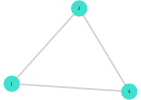

In [4]:
using Graphs
using GraphPlot

G₁ = Graph(3) # graph with 3 vertices

# make a triangle
add_edge!(G₁, 1, 2)
add_edge!(G₁, 1, 3)
add_edge!(G₁, 2, 3)

gplot(G₁, nodelabel=1:3)

Alternatively, one can construct a graph from its adjacency matrix:

In [5]:
A = [
    0 1 1
    1 0 1
    1 1 0
]

G₂ = Graph(A)

@assert G₁ == G₂

It is also possible to construct a graph with random edges using:

In [6]:
G = Graph(3, 3)

{3, 3} undirected simple Int64 graph

Notice that Graphs.jl checks the maximum number of edges for the given number of vertices, and throws an error if this maximum is not respected:

In [7]:
Graph(3, 4)

LoadError: AssertionError: Maximum number of edges for this graph is 3

The graphs just created are undirected, meaning that there is no sense of direction in the edges of the graph. To create a graph with directed edges, use:

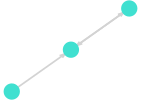

In [8]:
G = DiGraph(3,3)

gplot(G)

### Generators

For convenience, Graphs.jl comes with a set of built-in functions for generating famous graphs in the literature or graphs that resemble basic shapes in real life. These graphs could be constructed manually as described in the previous section and have nothing special in terms of the type system.

For constructing small graphs with simple shapes, one can use:

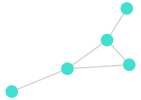

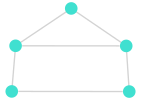

In [9]:
for shape in ["bull","house"]
    G = smallgraph(shape)
    display(gplot(G))
end

Many other generators are provided that can be used to construct graphs with specific properties. For example, a graph with `4`-connected `3`-cliques can be quickly sketched with:

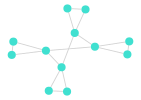

In [10]:
G = CliqueGraph(3,4)

gplot(G)

Please consult the documentation of Graphs.jl or the `src/generators` folder of the project for more generators. Contributions are very welcome.

## Graph properties

Now that we know how to construct graphs, let's query some basic properties from existing graphs, such as the number of vertices and edges, and compact matricial representations. Consider the simple house graph:

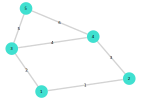

In [11]:
G = smallgraph("house")

nvertices = nv(G) # number of vertices
nedges = ne(G)    # number of edges

gplot(G, nodelabel=1:nvertices, edgelabel=1:nedges)

Notice from the numbering that the house was built from the floor to the roof, and that there are 5 vertices and 6 edges in the graph.

One can easily loop over these elements with:

In [12]:
for v in vertices(G)
    println("vertex $v")
end

vertex 1
vertex 2
vertex 3
vertex 4
vertex 5


In [13]:
for e in edges(G)
    u, v = src(e), dst(e)
    println("edge $u - $v")
end

edge 1 - 2
edge 1 - 3
edge 2 - 4
edge 3 - 4
edge 3 - 5
edge 4 - 5


Or obtain compact representations of the graph in matrix form:

In [14]:
adjacency_matrix(G)

5×5 SparseArrays.SparseMatrixCSC{Int64, Int64} with 12 stored entries:
 ⋅  1  1  ⋅  ⋅
 1  ⋅  ⋅  1  ⋅
 1  ⋅  ⋅  1  1
 ⋅  1  1  ⋅  1
 ⋅  ⋅  1  1  ⋅

In [15]:
incidence_matrix(G)

5×6 SparseArrays.SparseMatrixCSC{Int64, Int64} with 12 stored entries:
 1  1  ⋅  ⋅  ⋅  ⋅
 1  ⋅  1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  1  ⋅
 ⋅  ⋅  1  1  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  1

In [16]:
laplacian_matrix(G)

5×5 SparseArrays.SparseMatrixCSC{Int64, Int64} with 17 stored entries:
  2  -1  -1   ⋅   ⋅
 -1   2   ⋅  -1   ⋅
 -1   ⋅   3  -1  -1
  ⋅  -1  -1   3  -1
  ⋅   ⋅  -1  -1   2

## Basic operations

In the beginning of this tutorial, we have seen how graphs can be constructed from scratch by adding vertices and edges iteratively. For example, we can reconstruct the house graph using:

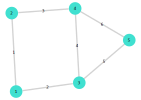

In [17]:
G = Graph()
add_vertices!(G, 5)
add_edge!(G, 1, 2)
add_edge!(G, 1, 3)
add_edge!(G, 2, 4)
add_edge!(G, 3, 4)
add_edge!(G, 3, 5)
add_edge!(G, 4, 5)

gplot(G, nodelabel=1:nv(G), edgelabel=1:ne(G))

In Graphs.jl, adding elements to a graph is **always** a safe operation in the sense that vertex and edge labels are preserved:

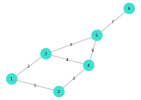

In [18]:
add_vertex!(G)
add_edge!(G, 5, 6)

gplot(G, nodelabel=1:nv(G), edgelabel=1:ne(G))

However, removing a vertex is **not** a *label-preserving* operation. For performance reasons, a vertex `k` is removed from the graph by swaping `k` with the latest vertex `nv(G)`. This side-effect is particularly relevant if data is being stored externally for each vertex or edge of the graph:

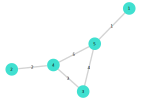

In [19]:
rem_vertex!(G, 1)

gplot(G, nodelabel=1:nv(G), edgelabel=1:ne(G))

### Set interface

Set-like operations are defined for graphs. For example, we can construct a very cool 3D airplane graph with the cartesian product between its framework (or skeleton) and squared metal plates:

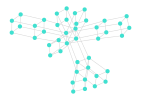

In [20]:
# metal plate
□ = Graph(4)
add_edge!(□, 1, 2)
add_edge!(□, 1, 3)
add_edge!(□, 2, 4)
add_edge!(□, 3, 4)

# airplane skeleton
skeleton = Graph(11)
add_edge!(skeleton, 1, 2)
add_edge!(skeleton, 2, 3)
add_edge!(skeleton, 3, 4)
add_edge!(skeleton, 4, 5)
add_edge!(skeleton, 3, 6)
add_edge!(skeleton, 3, 7)
add_edge!(skeleton, 3, 8)
add_edge!(skeleton, 3, 9)
add_edge!(skeleton, 9, 10)
add_edge!(skeleton, 9, 11)

gplot(cartesian_product(□, skeleton))

Many other operations, such as union, intersection, and complement are available and can be useful for manipulating graphs as first-class objects. Please check the documentation or the file `src/operators.jl` in the project for a complete list of operations.

## Conclusions

This basic tutorial covered the basic types defined in Graphs.jl and the various helper functions that the package provides for construction and manipulation of simple graphs. Please consult the other tutorials in this repository for more advanced features.